In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from scipy.stats import multivariate_normal
from scipy import fftpack
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.wcs as wcs
import numpy as np
import cmasher
import sys
import pandas as pd
plt.rcParams['font.size']=18
plt.rcParams['font.style']='normal'


def format_axes(plax,cax,lx='dr (rad)',ly='dd (rad)',clabel='IM'):
    plax.set_xticklabels('')
    plax.set_yticklabels('')
    plax.set_xlabel(lx)
    plax.set_ylabel(ly)
    cax.xaxis.tick_top()
    cax.yaxis.set_ticks(())
    cax.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax.set_xlabel(clabel,labelpad=-60)

def format_axes0(plax,lx='dr (rad)',ly='dd (rad)',clabel='IM'):
    plax.set_xticklabels('')
    plax.set_yticklabels('')
    plax.set_xlabel(lx)
    plax.set_ylabel(ly)

def plot_spectrum(grayscale_image,im_fft,wave=1e-3):
    # A logarithmic coormap
    aspect=plt.figaspect(0.5)
    f = plt.figure(figsize=aspect)
    left=0.15
    right=1.-left+0.05
    bottom=left
    top=1.-bottom
    grid = gs(1,2,wspace=0.3,hspace=0.3,
              #height_ratios=[0.05,1],
              left=left,right=right,top=top,bottom=bottom)
    ax0 = f.add_subplot(grid[0,0])
    ax1 = f.add_subplot(grid[0,1])
    #cax0 = f.add_subplot(grid[0,0])
    #cax1 = f.add_subplot(grid[0,1])
    pl0 = ax0.imshow(grayscale_image,alpha=None,
                     #cmap=cmasher.chroma,
                     interpolation='none'
                     )
    pl1 = ax1.imshow(im_fft,alpha=None,
                     #norm=plt.cm.colors.LogNorm(),
                     #cmap=cmasher.chroma,
                     interpolation='none',
                     )
    xticks0 = ax0.get_xticks()
    yticks0 = ax0.get_yticks()
    xticks1 = ax1.get_xticks()
    yticks1 = ax1.get_yticks()
    #cb0 = plt.colorbar(pl0,cax=cax0,orientation='horizontal')
    #cb1 = plt.colorbar(pl1,cax=cax1,orientation='horizontal')
    plax0 = pl0.axes
    plax1 = pl1.axes
    format_axes0(plax0,lx='dx (arcsec)',ly='dy (arcsec)')
    format_axes0(plax1,lx='log u (klambda)',ly='log v (klambda)',
                clabel='log(FT(IM))')
    #ax1.set_xticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks1)/wave)])
    #ax1.set_yticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks1)/wave)])
    #ax0.set_xticklabels(['{:.2f}'.format(t) for t in np.array((xticks0-np.max(xticks0/2))/np.pi*180/60/60)])
    #ax0.set_yticklabels(['{:.2f}'.format(t) for t in np.array((yticks0-np.max(yticks0/2))/np.pi*180/60/60)])
    #plt.tight_layout()
    return ax0,ax1

def plot_spectrum_with_ant(grayscale_image,im_fft,x_arr,y_arr):
    # A logarithmic coormap
    aspect=plt.figaspect(0.3)
    f = plt.figure(figsize=aspect)
    left=0.15
    right=1.-left+0.05
    bottom=left
    top=1.-bottom
    grid = gs(2,3,wspace=0.3,hspace=0.,
              height_ratios=[0.05,1],
              left=left,right=right,top=top,bottom=bottom)
    ax2 = f.add_subplot(grid[1,0])
    ax1 = f.add_subplot(grid[1,1])
    ax0 = f.add_subplot(grid[1,2])
    #cax0 = f.add_subplot(grid[0,0])
    #cax1 = f.add_subplot(grid[0,1])
    pl0 = ax0.imshow(grayscale_image,alpha=None,
                     #cmap=cmasher.chroma,
                     interpolation='none'
                     )
    xticks0 = ax0.get_xticks()
    yticks0 = ax0.get_yticks()
    pl1 = ax1.imshow(im_fft,alpha=None,
                     #norm=plt.cm.colors.LogNorm(),
                     #cmap=cmasher.chroma,
                     interpolation='none',
                     )
    xticks = ax1.get_xticks()
    yticks = ax1.get_yticks()
    pl2 = ax2.scatter(x_arr,y_arr)
    ax2.set_title('Antenna Location')
    ax2.set_xlabel('dx (km)')
    ax2.set_ylabel('dy (km)')
    ax2.set_xlim(-110,110)
    ax2.set_ylim(-110,110)
    #cb0 = plt.colorbar(pl0,cax=cax0,orientation='horizontal')
    #cb1 = plt.colorbar(pl1,cax=cax1,orientation='horizontal')
    plax0 = pl0.axes
    plax1 = pl1.axes
    format_axes0(plax0,lx='dr (arcsec)',ly='dd (arcsec)')
    format_axes0(plax1,lx='log u (wave)',ly='log v (wave)',
                clabel='log(FT(IM))')
    #ax1.set_xticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks*1e3)/wave)])
    #ax1.set_yticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks*1e3)/wave)])
    #ax0.set_xticklabels(['{:.2f}'.format(t) for t in np.array((xticks0-np.max(xticks0/2))/np.pi*180/60/60)])
    #ax0.set_yticklabels(['{:.2f}'.format(t) for t in np.array((yticks0-np.max(yticks0/2))/np.pi*180/60/60)])
    #plt.tight_layout()
    return ax0,ax1
    

def add_fourier_component(im,nx,ny,r,peak,angle):
    xr = int(np.sin(angle)*r)
    yr = int(np.cos(angle)*r)
    x0,y0 = int(nx/2-xr/2), int(ny/2-yr/2)
    x1,y1 = int(nx/2+xr/2), int(ny/2+yr/2)
    im[x0,y0] = peak
    im[x1,y1] = peak
    return im
    


# Read in information on our telescope array

We read in the 12m antennae locations of configuration 5 from ALMA Cycle 7. Units are in meters. Although we ignore vertical offsets ($z$) in our simple interferometer calculations below, we've plotted the antenna locations and colorized by $z$.

             x            y          z  diam   pad
0    15.934535  -700.675748  -2.329676  12.0  A007
1    37.826178  -735.876082  -2.484749  12.0  A011
2    10.739879  -659.567364  -2.726262  12.0  A015
3   -43.644072  -652.742461  -2.322697  12.0  A022
4   -74.474616  -684.657459  -2.129343  12.0  A024
5   -93.142925  -745.959481  -1.941493  12.0  A027
6  -105.438738  -755.003357  -1.640753  12.0  A033
7     2.382623  -763.285557  -2.838873  12.0  A042
8    17.105372  -766.533803  -2.842287  12.0  A043
9   -63.505212  -786.819957  -1.341061  12.0  A045
10  -19.653997  -794.595231  -2.338743  12.0  A047
11  -45.350247  -846.397206  -1.848567  12.0  A058
12   -5.289168  -862.853826  -1.546623  12.0  A060
13  -79.543802  -828.939797  -1.295599  12.0  A062
14  -54.711817  -616.689221  -2.521178  12.0  A066
15 -140.507228  -651.164080  -0.634931  12.0  A068
16 -159.551608  -789.469025  -0.085067  12.0  A069
17  108.097794  -762.866636  -4.094737  12.0  A070
18   89.093953  -599.959700  -5

Text(0, 0.5, 'y (m)')

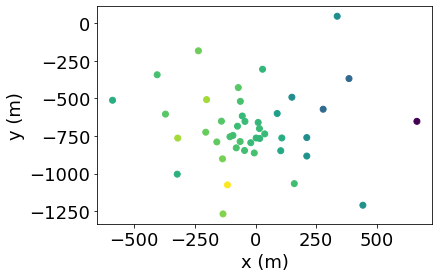

In [2]:
# Telescope array

# read in telescope coordinates
names = ['x','y','z','diam','pad']
config = pd.read_csv('alma.cycle7.5.cfg',
                     sep='\s+',
                     skiprows=3,
                     names=names)
print(config)
#im = np.zeros_like(vis)
x_arr = config['x'].values
y_arr = config['y'].values
z_arr = config['z'].values

plt.scatter(x_arr,y_arr,c=z_arr)
plt.xlabel("x (m)")
plt.ylabel("y (m)")




# Model the Brightness Distribution of a 2D Gaussian source

In this section, we define a simple two-dimensional, Gaussian source in the sky. We will assume that the source is identical at all wavelengths.

Source emitting pattern on sky:

$f(\alpha,\delta) = \frac{A}{\sigma_\alpha \sigma_\delta 2\pi}\mathrm{exp}\left(\frac{(\alpha - \mu_\alpha)^2}{2\sigma_\alpha^2} + \frac{(\delta - \mu_\delta)^2}{2\sigma_\delta^2}\right)$


Basic source information:
* Central RA, Dec: $\mu_\alpha=12^h 01^m 53.170$, $\mu_\delta=-18^d 52^m 37.92$
* FWHM of Gaussian: $1''$, $\sigma_\alpha=\sigma_\delta=\mathrm{FWHM}/\sqrt{8\mathrm{ln}2}$
* Peak brightness of Gaussian: $f(\mu_\alpha,\mu_\delta)=\frac{A}{\sigma_\alpha \sigma_\delta \sqrt{2\pi}}=10$ $\rm{K}$

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.4715416666667  -18.8772  
CRPIX : 500.0  500.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -2.7777777777777e-06  2.77777777777777e-06  
NAXIS : 1000  1000


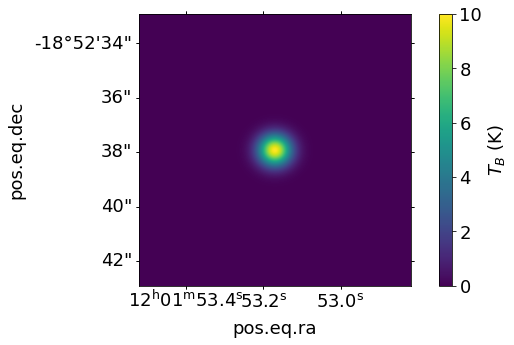

In [3]:
def gaussian_2d(alpha,delta,sigma_alpha,sigma_delta,mu_alpha,mu_delta,A):
    g1 = (alpha-mu_alpha)**2/(2*sigma_alpha**2)
    g2 = (delta-mu_delta)**2/(2*sigma_delta**2)
    return A/(sigma_alpha*sigma_delta*2*np.pi)*np.exp(-(g1 + g2))

# center RA, Dec
coord = SkyCoord('12h01m53.170','-18d52m37.92')
FWHM = 1*u.arcsec.to(u.degree)*u.degree
peak = 10*u.K

mu_alpha = coord.ra
mu_delta = coord.dec
sigma_alpha = FWHM/np.sqrt(8*np.log(2))
sigma_delta = FWHM/np.sqrt(8*np.log(2))
A = peak*sigma_alpha*sigma_delta*2*np.pi

# We define some basic WCS information: 
# We consider a 1000x1000 grid
naxis1 = 1000
naxis2 = 1000
dx = 10*u.arcsec.to(u.degree)
dy = 10*u.arcsec.to(u.degree)

# We consider an area of 10x10 arcsec, but write to the header in units of degrees
cdelt1 = -dx/naxis1
cdelt2 = dy/naxis2

# We place our source at the center of our grid
crpix1 = naxis1/2
crpix2 = naxis2/2
crval1 = mu_alpha.value # deg
crval2 = mu_delta.value

header = fits.Header()
header['CRVAL1'] = crval1
header['CRVAL2'] = crval2
header['CRPIX1'] = crpix1
header['CRPIX2'] = crpix2
header['CDELT1'] = cdelt1
header['CDELT2'] = cdelt2
header['CUNIT1'] = 'deg'
header['CUNIT2'] = 'deg'
header['CTYPE1'] = 'RA---SIN'
header['CTYPE2'] = 'DEC--SIN'
header['NAXIS1'] = naxis1
header['NAXIS2'] = naxis2

w = wcs.WCS(header)
print(w)

grid = np.meshgrid(np.arange(0,naxis1),
                 np.arange(0,naxis2))
x = grid[0].ravel().astype(int)
y = grid[1].ravel().astype(int)
alpha,delta = w.all_pix2world(x,y,0)

source = gaussian_2d(alpha,delta,sigma_alpha.value,sigma_delta.value,mu_alpha.value,mu_delta.value,A.value)
source[source < 0] = np.nan

im = np.empty(grid[0].shape)
im[x,y] = source

grid = gs(1,1)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(grid[0],projection=w)
pl = ax.imshow(im)
plt.colorbar(pl,label=r'$T_B$ (K)')


# Convert Model Source Coordinates to Directional Cosines $(l,m,n)$

The $u,v,w$ coordinate system is used by radio interferometers, such that $u$ and $v$ point East and North, respectively, and $w$ typically points towards our source in the direction of $\hat{s_0}$. An interferometer will observe the projection of the source onto the $u,v,w$-plane. The source distribution pattern is $I(\hat{s})=I(l,m,n)$, such that $\hat{s}$ is comprised of the directional cosines $(l,m,n)$. 

The conversion from the sky plane coordinates ($\alpha$, $\delta$) to directional cosines can be done via:

* $l = \mathrm{cos}(\delta)\mathrm{sin}(\alpha-\alpha_0)$
* $m = \mathrm{sin}(\delta)\mathrm{cos}(\delta_0)-\mathrm{cos}(\delta_0)\mathrm{sin}(\delta_0)\mathrm{cos}(\alpha-\alpha_0)$
* $n=\mathrm{cos}(\theta)=\sqrt{1-l^2-m^2}$ where $\theta$ is the azimuthal angle with respect to $w$ (and $\hat{s_0}$)

where $\alpha_0$ and $\delta_0$ are the chosen phase center. We choose $\alpha_0=\mu_\alpha$ and $\delta_0=\mu_\delta$.

In [4]:
def sky_to_lmn(alpha,delta,alpha_0,delta_0):
    l = np.cos(delta)*np.sin(alpha-alpha_0)
    m = np.sin(delta)*np.cos(delta_0)-np.cos(delta_0)*np.sin(delta_0)*np.cos(alpha-alpha_0)
    n = np.sqrt(1 - l**2 - m**2)
    return l,m,n

l,m,n = sky_to_lmn(alpha*np.pi/180.,delta*np.pi/180.,mu_alpha.value*np.pi/180.,mu_delta.value*np.pi/180.)
theta = np.arccos(n)

# Calculate baseline and visibility information

Some variables:
* $\theta$: angle of the source in the sky with respect to the phase center
* $c \tau_g$: difference in path length that a light wave with speed $c$ will travel in time $\tau_g$
* $B$: baseline distance

The geoemtric delay of the signal between a pair of telescopes is also equivalent to:
$c\tau_g = B \mathrm{sin}\theta$

The combined, correlated voltage signal from a pair of telescopes is given by: $V = E^2[1 + \mathrm{cos}(2\pi\nu\tau_g)]$, where $E$ is the amplitude dependent on the strength of our source. Accounting for the time delay, we get the fringe function for a signal with wavelength $\theta$:
$F = E^2\left[1 + \mathrm{cos}\left(\frac{2\pi B\mathrm{sin}\theta}{\lambda}\right)\right]$

For an array of 60 antennas, we get $N(N-1)/2=1770$ baselines.


In [5]:
# For an array of 60 antennae
x_arr = x_arr.astype('int')
y_arr = y_arr.astype('int')

# Pick an arbitraty angle corresponding to source angle at observation
theta = 45.*np.pi/180. # angle of source w.r.t. azimuth, must be in radians

# Calulate baseline lengths of telescope pairs
a_arr = np.ones_like(x_arr)
grid = np.meshgrid(x_arr, y_arr)
k=0
ij = []
for i in np.arange(len(x_arr)):
    for j in np.arange(i+1,len(y_arr)):
        ij.append((i,j))

ij = np.vstack(ij)
B = np.sqrt((x_arr[ij[:,0]]-x_arr[ij[:,1]])**2 + (y_arr[ij[:,0]]-y_arr[ij[:,1]])**2)*u.m # meters
B_angle = np.arctan((y_arr[ij[:,0]]-y_arr[ij[:,1]])/(x_arr[ij[:,0]]-x_arr[ij[:,1]]))


#im_fft = fftpack.fft2(im)
#amp = np.nan_to_num(np.abs(np.real((im_fft))))
#phase = np.nan_to_num(np.abs(np.imag((im_fft))))

#u = x/wave
#v = y/wave

wave = 1*u.mm.to(u.m)
b_u = (x_arr[ij[:,0]]-x_arr[ij[:,1]])/wave
b_v = (y_arr[ij[:,0]]-y_arr[ij[:,1]])/wave
b_w = (z_arr[ij[:,0]]-z_arr[ij[:,1]])/wave

# Calculate time delay between individual telescopes, in seconds
tau_g = B*np.sin(theta)/const.c

# Calculte the voltage signal from a pair of

u_arr0 = B/2*np.cos(a_arr[ij[:,0]])
v_arr0 = B/2*np.sin(a_arr[ij[:,0]])
u_arr1 = B/2*np.cos(a_arr[ij[:,1]])
v_arr1 = B/2*np.sin(a_arr[ij[:,1]])


# Calculate amplitude of visibilities
pairs = np.vstack([(int(x_),int(y_)) for x_,y_ in zip(x_arr,y_arr)])


<ipython-input-5-25ad1fb6d2ca>:19: RuntimeWarning: divide by zero encountered in true_divide
  B_angle = np.arctan((y_arr[ij[:,0]]-y_arr[ij[:,1]])/(x_arr[ij[:,0]]-x_arr[ij[:,1]]))


In [6]:
#fft_source = fftpack.fft2(source)
#fft_source = np.abs(fft_source)
sky = convolve2d(uv,source)
f3 = plt.figure(figsize=figsize*2)
ax3 = f3.add_subplot(111)
ax3.imshow(sky)

NameError: name 'convolve2d' is not defined

In [ ]:
data = fftpack.fft2(sky)
data = np.abs(data)
f5 = plt.figure(figsize=figsize*2)
ax5 = f5.add_subplot(111)
ax5.imshow(data,norm=plt.cm.colors.LogNorm())